# XY-calibration (F1)

In [1]:
cd ..

/Users/Vincent/Github/FireBallPipe


In [72]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from Calibration.mapping import Mapping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## initialization from last xy calib
---------------------------------

In [3]:
# prerequisites:
Field = "F1"
previous_xy_mapping = 'Notebook/Files/Guider2UV_%s_nogamma.new.pkl'%(Field)
mask_det_map_file = "Calibration/Mappings/2022/mapping-mask-det-w-2022-5-%s.pkl"%(Field)
target_filename = 'Calibration/Targets/2022/targets_%s.txt'%(Field)
mapping_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/%s/%s_2022_6_-82.fits"%(Field,Field)
new_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/%s/%s_2022_6_-106.fits"%(Field,Field)
# encoder gains:

CEg = 1.02928
Elg = 1.00379

In [4]:
# load model from previous XY calib 
G2UV = Guider2UV(filename=previous_xy_mapping)
print(G2UV)

## eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1. 

# if you already know the approx angular distance between guidercenter and FOVcenter, set it:
#G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
#                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
#                                                    frame = G2UV.GuiderP.localframe)


# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)



FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>): (lon, lat) in deg
    (0.17639951, 0.0154012)>
FOV center pixel position in guider [array(1338.56657245), array(600.7867847)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.392728151  36.4185638082  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024551548564194  0.00024661678545423  
NAXIS : 0  0

    mask_rotation: 83.96815071133501 arcmin
 

## Alternative initialisation for new fields:
---------------------------------------

In [5]:

# # prerequisites:
# previous_xy_mapping = 'Notebook/Files/Guider2UV_F1_nogamma.new.pkl'
# mask_det_map_file = "Calibration/Mappings/2022/mapping-mask-det-w-2022-5-F1.pkl"
# target_filename = 'Calibration/Targets/2022/targets_F1.txt'
# mapping_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/F1/F1_2022_6_-82.fits"
# new_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/F1/F1_2022_6_-106.fits"

# f_ra, f_dec, f_rot = 0, 0, 0
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )
                 
# FNEW = Table.read(target_filename, format='ascii')
# mask_det_map = Mapping(mask_det_map_file)

# # print(G2UV)

## 1-  Rotate mask carousel
## 2- Diffuse UV image

In [6]:
# data1 = fits.open(mapping_diffuse_image)[0].data[1404:1500,1925:2080]
# data2 = fits.open(new_diffuse_image)[0].data[1404:1500,1925:2080]
# data1 = (data1-data1.min()) / (data1-data1.min()).ptp()
# data2 = (data2-data2.min()) / (data2-data2.min()).ptp()
# fig, axes = heatmap_slicer(
#     np.arange(data2.shape[1]),
#     np.arange(data2.shape[0]),
#     (data1, data2),
#     slices="both",
#     figsize = (8,8),
#     heatmap_names=("Old diffuse image", "Map based diffuse"),
#     labels=("Some wild X variable", "Y axis"),
#     interaction_type="click")
# plt.tight_layout()
# plt.show()



Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [55]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
offset = np.array([-8.8408, 0.97131])
G2UV.set_detector_mapping(mask_det_map, offsets = offset)


## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

GC - 46 - 51 - 19 - 8 - 12 - 10 - 38 - 43

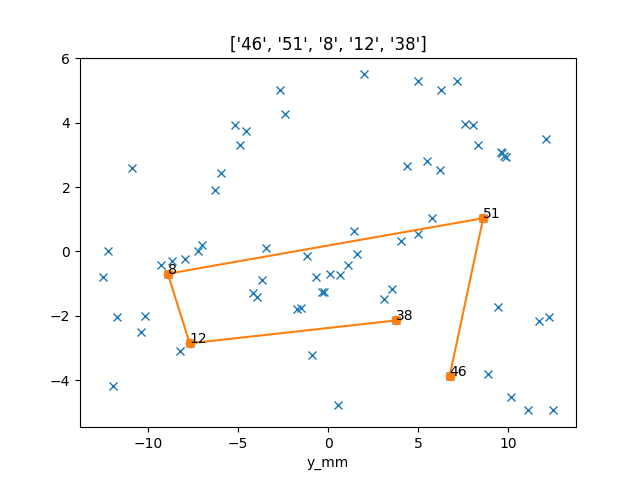

Internal-count,x_mm,y_mm,ra,dec
str2,float64,float64,float64,float64
46,6.7589561,-3.858979,32.350896,-5.779373
51,8.6160157,1.0303866,32.395107,-5.663555
8,-8.8972191,-0.6960435,31.97817,-5.704451
12,-7.6793793,-2.8581218,32.007183,-5.755669
38,3.7831595,-2.1462593,32.279995,-5.738793
38,3.7831595,-2.1462593,32.279995,-5.738793
12,-7.6793793,-2.8581218,32.007183,-5.755669
8,-8.8972191,-0.6960435,31.97817,-5.704451
51,8.6160157,1.0303866,32.395107,-5.663555


In [56]:
slits = ['46', '51', '14', '8', '12', '16', '38', '44']  #2018
slits = ['46', '51', '19', '8', '12', '10', '38', '43']  # 2022 because 44 and 14 are not visible in 213.9. need to bee thought
slits = ['46', '51',  '8', '12','38']  # 2022 because 44 and 14 are not visible in 213.9. need to bee thought
# mask = F1.to_pandas()['Internal-count'].isin(slits)
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

plt.figure()
plt.plot(F1["x_mm"],F1["y_mm"],"x")
plt.plot(selected_slits["x_mm"],selected_slits["y_mm"],"-o")
for s in selected_slits:
    plt.text(s["x_mm"],s["y_mm"],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title(slits)
plt.show()

selected_slits = selected_slits['Internal-count',"x_mm","y_mm","ra","dec"]
slit_path = vstack((selected_slits,selected_slits[::-1]) )
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path


# selected_slits

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [61]:

moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = True)
moves_tab = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
assert moves.sum(axis=0)[0] <0.1
assert moves.sum(axis=0)[1] <0.1

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves_tab.to_clipboard()
except Exception:
    pass
moves_tab 



slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit position in mm on mask: [8.6160157 1.0303866]
slit position in mm on mask: [-8.8972191 -0.6960435]
slit position in mm on mask: [-7.6793793 -2.8581218]
slit position in mm on mask: [ 3.7831595 -2.1462593]

targets local coords in siderostat local frame:
EL: 175.4 arcsec ; CE: 318.4 arcsec
EL: 389.3 arcsec ; CE: 396.5 arcsec
EL: 310.1 arcsec ; CE: -348.9 arcsec
EL: 216.0 arcsec ; CE: -296.5 arcsec
EL: 249.6 arcsec ; CE: 191.2 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image
0,0.000000,-30.000000,0.0
1,-0.000000,30.000000,1.0
2,175.436833,318.359642,1.0
3,213.834344,78.101040,1.0
4,-79.174771,-745.348160,1.0
5,-94.114226,52.375844,1.0
6,33.628239,487.730912,1.0
7,-0.000000,30.000000,0.0
8,0.000000,-30.000000,1.0
9,-33.628239,-487.730912,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [62]:

slits_coord_obs_det = np.array([
[1744.5149,	709.2633],
[2074.3496,	567.48754],
[1959.6651,	1885.5387],
[1813.3748,	1795.4066],
[1856.6138,	932.35271],
[1856.4786,	931.65825],
[1813.6749,	1794.3482],
[1959.5905,	1885.554],
[2071.5012,	576.32861],
[1744.3718,	708.52823]])

slit_path["x_det_obs"] = slits_coord_obs_det[:,0]
slit_path["y_det_obs"] = slits_coord_obs_det[:,1]
#TODO should add difference
slit_path
# slit_path.write("/tmp/slit.csv",overwrite=True)



Internal-count,x_mm,y_mm,ra,dec,x_det_obs,y_det_obs
str2,float64,float64,float64,float64,float64,float64
46,6.7589561,-3.858979,32.350896,-5.779373,1744.5149,709.2633
51,8.6160157,1.0303866,32.395107,-5.663555,2074.3496,567.48754
8,-8.8972191,-0.6960435,31.97817,-5.704451,1959.6651,1885.5387
12,-7.6793793,-2.8581218,32.007183,-5.755669,1813.3748,1795.4066
38,3.7831595,-2.1462593,32.279995,-5.738793,1856.6138,932.35271
38,3.7831595,-2.1462593,32.279995,-5.738793,1856.4786,931.65825
12,-7.6793793,-2.8581218,32.007183,-5.755669,1813.6749,1794.3482
8,-8.8972191,-0.6960435,31.97817,-5.704451,1959.5905,1885.554
51,8.6160157,1.0303866,32.395107,-5.663555,2071.5012,576.32861


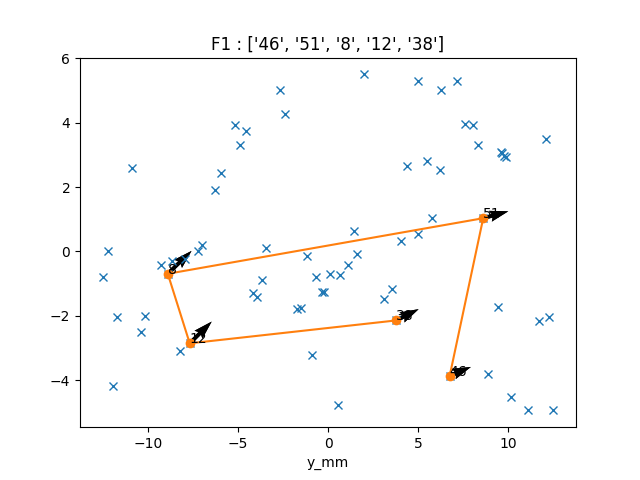

In [63]:
# TODO create some quiver of the error
plt.figure()
plt.plot(F1["x_mm"],F1["y_mm"],"x")
plt.plot(selected_slits["x_mm"],selected_slits["y_mm"],"-o")
for s in selected_slits:
    plt.text(s["x_mm"],s["y_mm"],s["Internal-count"])
plt.quiver(slit_path["x_mm"],slit_path["y_mm"],slit_path["x_det_obs"],slit_path["y_det_obs"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title(Field + " : %s"%(slits))
plt.show()

In [64]:
valid = np.isfinite(slits_coord_obs_det[:,0])
#valid = np.array([True]*8 + [False]*8)
try:
    obs_wave = G2UV.mask_det_map.w[0]
except TypeError:
    obs_wave = 0.2139
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
slits_valid = np.array(slits + slits[::-1])[valid]

wave:  0.2139


### look at siderostat frame hysteresis 

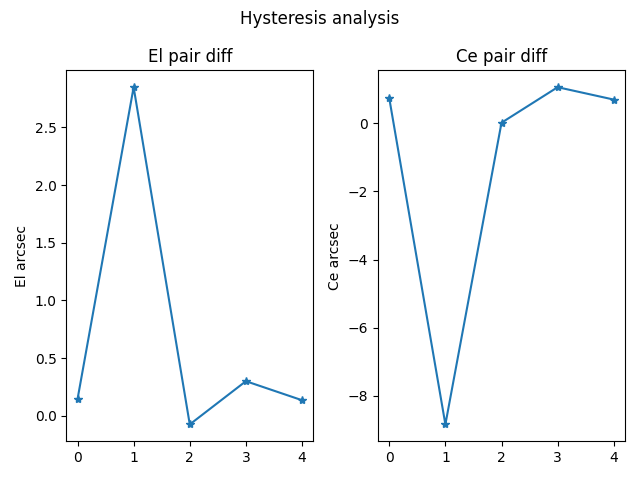

In [66]:
# mid  = len(slits_coord_obs_det)//2
# pair_diff = slits_coord_obs_det[:mid] - slits_coord_obs_det[::-1][:mid]
# pair_diff
# fig, (ax0,ax1) = plt.subplots(1,2)
# ax0.plot(np.abs(pair_diff[:,0]),'*')
# ax0.plot(np.abs(pair_diff[:,0]),'-')
# ax0.set_title("El pair diff")
# ax0.set_ylabel("El arcsec")
# ax1.plot(np.abs(pair_diff[:,1]),'*')
# ax1.plot(np.abs(pair_diff[:,1]),'-')
# ax1.set_title("Ce pair diff")
# ax1.set_ylabel("Ce arcsec")
# fig.suptitle(Field + " : Hysteresis analysis")
# fig.tight_layout()

moves_sign  = np.sign(moves[2:mid+2])
pair_diff_signed = pair_diff * moves_sign
valid = np.arange(len(moves_sign))#[0,2,3,4]
fig, (ax0,ax1) = plt.subplots(1,2)
ax0.plot(pair_diff_signed[valid,0],'*-')
ax0.set_title("El pair diff")
ax0.set_ylabel("El arcsec")
ax1.plot(pair_diff_signed[valid,1],'*-')
ax1.set_title("Ce pair diff")
ax1.set_ylabel("Ce arcsec")
fig.suptitle("Hysteresis analysis")
fig.tight_layout()


## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

Fitting rotation, translation and magnification
gamma: 1.027810286566071
theta: 16.77292685074135 arcmin
dx: 32.43286074183997 arcsec
dy: -123.75359441150542 arcsec
variances: [4.77321462e-04 1.64091031e+00 4.10628864e-01 4.10628864e-01]

residuals in arcsec: [[-4.20242294 -0.67806469]
 [ 6.23535574  0.2041735 ]
 [ 2.18789986 -0.7120277 ]
 [-0.37066237  1.05519932]
 [-2.02392892 -3.27564381]
 [-2.20542231 -4.06373914]
 [ 0.02771571 -0.14932013]
 [ 2.09052485 -0.69439335]
 [ 2.6615486   9.8232415 ]
 [-4.40060824 -1.5094255 ]]
max residual in EL,CE 6.2, 9.8 arcsec
mean residual in EL,CE 3.2, 3.6 arcsec


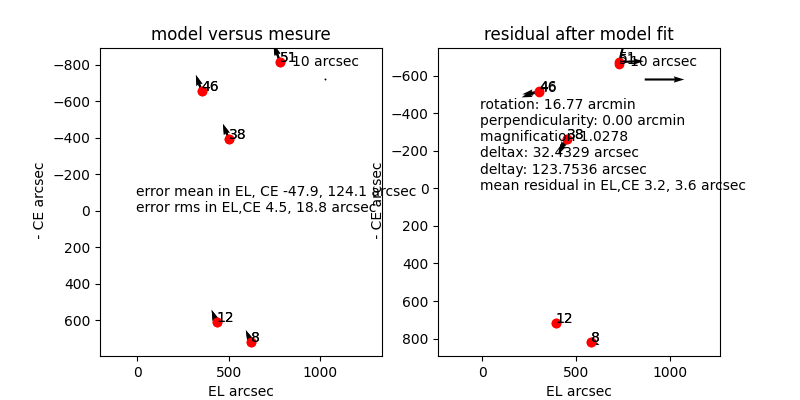

In [71]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, labels=slits_valid, plot=True)


### save corrected model for future use (eg redo the clalib on same field)

In [16]:
G2UVcor.save(filename="Calibration/Mappings/2022/XY/%s_XY_%s.pkl"%(Field,datetime.datetime.now().strftime("%y%m%d")))

Dumping to Calibration/Mappings/2022/XY/F1_XY_prep.pkl


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

In [73]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = True)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves.to_clipboard()
moves

slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit position in mm on mask: [8.6160157 1.0303866]
slit position in mm on mask: [-8.8972191 -0.6960435]
slit position in mm on mask: [-7.6793793 -2.8581218]
slit position in mm on mask: [ 3.7831595 -2.1462593]

targets local coords in siderostat local frame:
EL: 198.1 arcsec ; CE: 386.5 arcsec
EL: 418.3 arcsec ; CE: 465.8 arcsec
EL: 333.1 arcsec ; CE: -300.0 arcsec
EL: 236.6 arcsec ; CE: -245.7 arcsec
EL: 273.7 arcsec ; CE: 255.5 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image
0,0.000000,-30.000000,0.0
1,-0.000000,30.000000,1.0
2,198.099670,386.524393,1.0
3,220.188055,79.229257,1.0
4,-85.211159,-765.707868,1.0
5,-96.464600,54.293994,1.0
6,37.072176,501.142537,1.0
7,-0.000000,30.000000,0.0
8,0.000000,-30.000000,1.0
9,-37.072176,-501.142537,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence 
gc - s8 - s25 - s31

In [18]:
star_target_path = "Calibration/Targets/2022/GuidingStars/F1_guidingstars.fits"

F1_stars = Table.read(star_target_path, format='fits').to_pandas()

stars = [8, 25, 31]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = True)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])

stars_path = vstack((selected_stars,selected_stars[::-1]) )
selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
print("(They have been copied to clipboard, paste it in the spreadsheet)")
star_moves.to_clipboard()
star_moves




targets local coords in siderostat local frame:
EL: 165.0 arcsec ; CE: -123.5 arcsec
EL: 184.0 arcsec ; CE: 85.4 arcsec
EL: 114.8 arcsec ; CE: 143.2 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,Image
0,-0.000000,30.000000,0.0
1,0.000000,-30.000000,1.0
2,164.981636,-123.477285,1.0
3,19.001383,208.858538,1.0
4,-69.200811,57.806938,1.0
5,-0.000000,30.000000,0.0
6,0.000000,-30.000000,1.0
7,69.200811,-57.806938,1.0
8,-19.001383,-238.858538,0.0
9,0.000000,30.000000,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [19]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
8,32.1014,-5.786504,-3.751016,-4.191964,11,11,11,954.7166340246686,952.1343510310977
25,32.221491,-5.776507,1.333233,-3.766303,9,--,--,990.2173692400569,476.91827039575276
31,32.254526,-5.815258,2.731668,-5.415391,--,12,12,836.6074480025399,344.4301880821129
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------